# Setup

In [1]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [2]:
# load baselines: filename!!
with open('results/baselines_regular_classes.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

# load results; filename
with open('results/cuts_regular_classes_FR.json', 'r') as f:
    results = json.load(f)
params = results[0]
results = results[1:]
results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

df_empirical = pd.DataFrame(baselines + results)
df_empirical.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

df_empirical.tail()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
635,0.001,1.0,6,0,0.971618,0.971466
636,0.001,1.0,6,1,0.970927,0.971058
637,0.001,1.0,6,2,0.970351,0.970412
638,0.001,1.0,6,3,0.966741,0.966739
639,0.001,1.0,6,4,0.972502,0.972011


# 1. The plots
First the one on the left, and the one on the right (with the hatches)

/home/arnisa/anaconda3/envs/tutorial6_env/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Freeze = True, Reinitialize = True, Pooling = True, Learning rate = 0.001


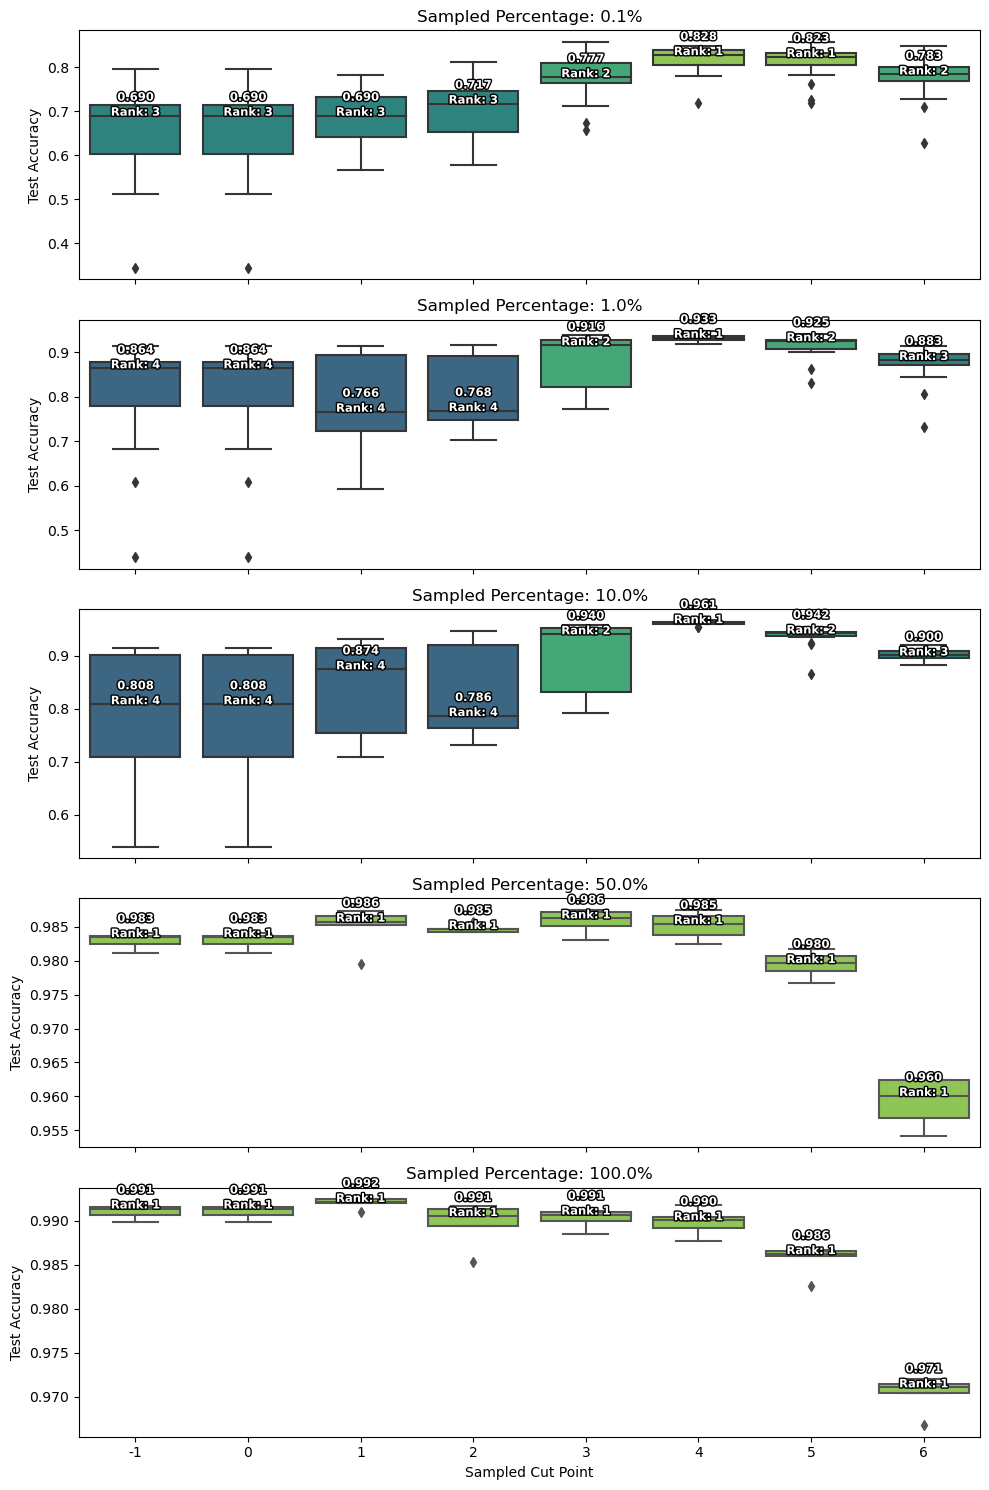

In [3]:
# run statistical tests below to get the df_rankings
_, df_rankings = get_rankings(df=df_empirical)
ranks_sorted = box_plot(df=df_empirical, rank_df=df_rankings, params=params, add_baseline=False)

<module 'matplotlib.pyplot' from '/home/arnisa/anaconda3/envs/tutorial6_env/lib/python3.7/site-packages/matplotlib/pyplot.py'>

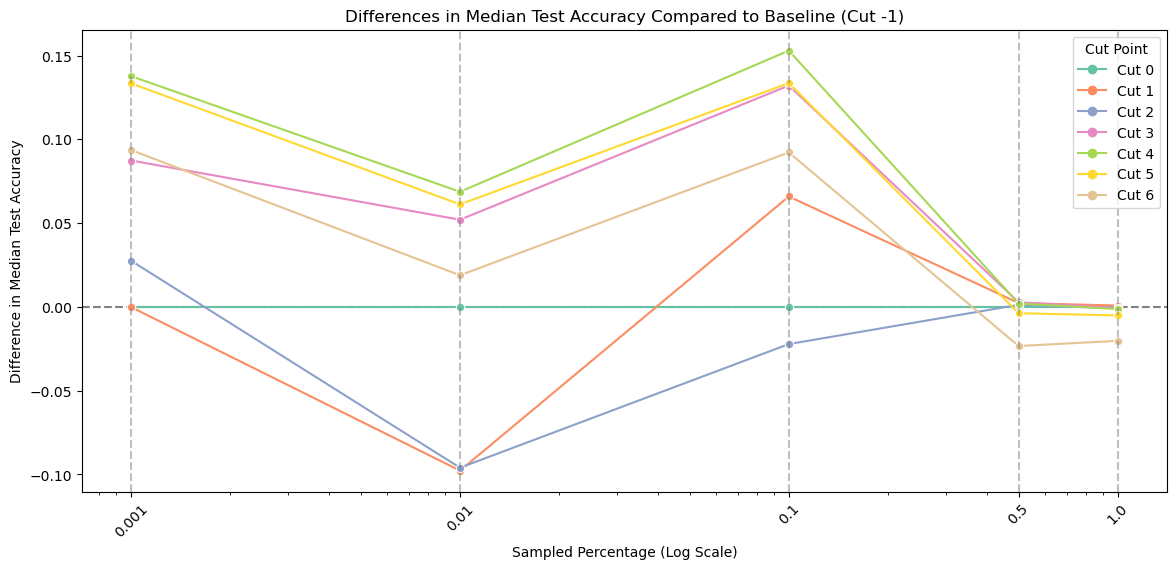

In [4]:
compare_to_baseline_line_plot(df_empirical)

<module 'matplotlib.pyplot' from '/home/arnisa/anaconda3/envs/tutorial6_env/lib/python3.7/site-packages/matplotlib/pyplot.py'>

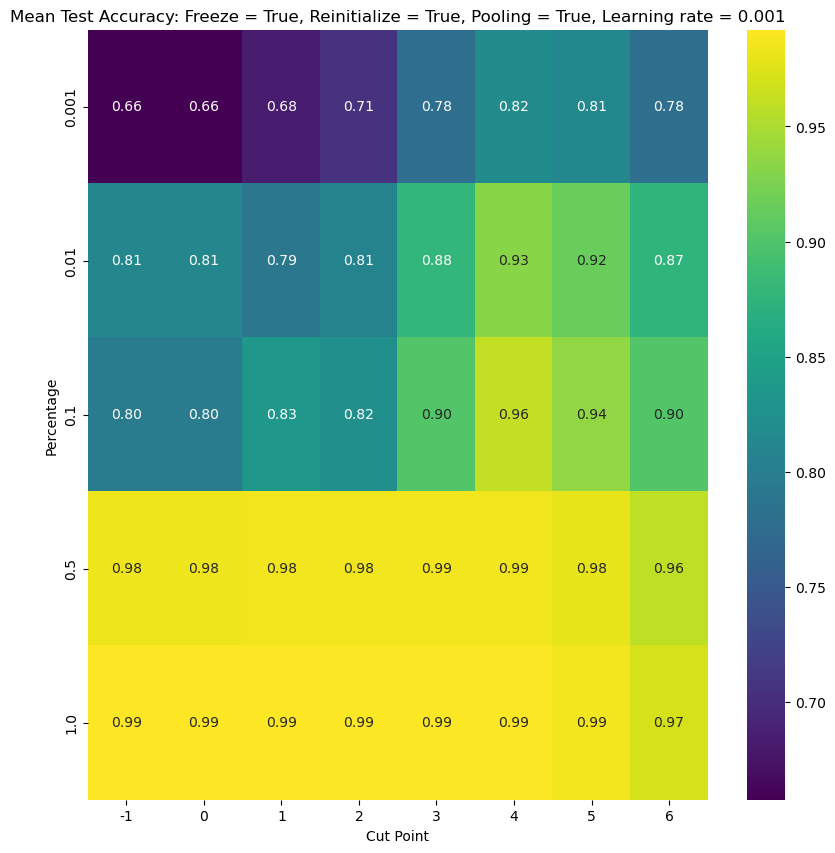

In [5]:
heatmap(df_empirical, params, figsize=(10,10))

# 2. Statistical Tests

### Tables for Ranking Cuts

In [6]:
df_wilcoxon_pairwise, _ = get_rankings(df=df_empirical)

df_wilcoxon_pairwise["statistic"] = df_wilcoxon_pairwise["statistic"].astype(int)

latex_table = df_wilcoxon_pairwise.to_latex(index=False, float_format="%.6f")

rows = latex_table.split("\n")[4:-3]
header = latex_table.split("\n")[:4]
footer = latex_table.split("\n")[-3:]

# iterate over the rows and the df_wilcoxon_pairwise
for i, row in enumerate(rows):
    # print(row)
    row = row.split(" & ")   
    # print(float(row[0].lstrip())*100)
    row = " & ".join([str(float(row[0].lstrip())*100)[:5]] + row[1:-1])
    if df_wilcoxon_pairwise.iloc[i]["is_significant"]:
        row = "\\rowcolor{green!20}\n" + row
    
    rows[i] = row + " \\\\"

# join the header, rows and footer, putting a "\\" at the end of each row
latex_table = "\n".join(rows)

/home/arnisa/anaconda3/envs/tutorial6_env/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [7]:
print(latex_table)

0.1 &           -1 &            0 &          0 & 1.000000 \\
0.1 &           -1 &            1 &        127 & 0.352520 \\
\rowcolor{green!20}
0.1 &           -1 &            2 &         77 & 0.020275 \\
\rowcolor{green!20}
0.1 &           -1 &            3 &          1 & 0.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            4 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            5 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            6 &          0 & 0.000000 \\
0.1 &            0 &            1 &        127 & 0.352520 \\
\rowcolor{green!20}
0.1 &            0 &            2 &         77 & 0.020275 \\
\rowcolor{green!20}
0.1 &            0 &            3 &          1 & 0.000000 \\
\rowcolor{green!20}
0.1 &            0 &            4 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &            0 &            5 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &            0 &            6 &          0 & 0.000000 \\
0.1 &  